In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

!pip install catboost
from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings('ignore')


### Загрузка и анализ данных

In [2]:
train = pd.read_csv('train.csv')
players_feats = pd.read_csv('players_feats.csv')
test = pd.read_csv('test.csv')

In [3]:
%%javascript 
IPython.OutputArea.auto_scroll_threshold = 9999; 

<IPython.core.display.Javascript object>

In [4]:
#функция с выводом основной информации для анализа датасетов

def get_title(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

def df_info(df, title):
    print()
    print('\033[4m\033[1m' + ''.join(title) +'\033[0m\033[0m')
    display(df.head(10))
    print()
    print('Размер данных', title)
    display(df.shape)    
    print()    
    print('Общая информация о', title) 
    print()
    display(df.info())
    print('Пропуски в', title) 
    report = df.isna().sum().to_frame().rename(columns = {0: 'missing_values'})
    report['% of total'] = ((report['missing_values'] / df.shape[0]).round(2))*100
    display(report.sort_values(by = 'missing_values', ascending = False))
    print()
    print('Полных дубликатов в', title, df.duplicated().sum())

In [5]:
for i in train, players_feats, test:
    df_info(i, get_title(i))


train


,map_id,team1_id,team2_id,map_name,who_win
0,289,6665,7718,Ancient,0
1,715,4411,10577,Inferno,0
2,157,11251,9455,Nuke,1
3,524,4608,7532,Mirage,0
4,404,8637,6667,Overpass,1
5,474,4869,5752,Mirage,1
6,84,5005,11588,Overpass,0
7,208,6667,5752,Inferno,1
8,626,6665,11654,Ancient,0
9,692,6665,4411,Nuke,0



Размер данных train


(713, 5)


Общая информация о train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713 entries, 0 to 712
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   map_id    713 non-null    int64 
 1   team1_id  713 non-null    int64 
 2   team2_id  713 non-null    int64 
 3   map_name  713 non-null    object
 4   who_win   713 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 28.0+ KB


None

Пропуски в train


,missing_values,% of total
map_id,0,0.0
team1_id,0,0.0
team2_id,0,0.0
map_name,0,0.0
who_win,0,0.0



Полных дубликатов в train 0

players_feats


,p1_id,p1_total_kills,p1_headshots,p1_total_deaths,p1_kd_ratio,p1_damage_per_round,p1_grenade_damage_per_round,p1_maps_played,p1_rounds_played,p1_kills_per_round,...,p5_kill_death_difference,p5_total_opening_kills,p5_total_opening_deaths,p5_opening_kill_ratio,p5_opening_kill_rating,p5_team_win_percent_after_first_kill,p5_first_kill_in_won_rounds,team_id,map_name,map_id
0,4954,90,42.2,112,0.80,76.3,5.9,6,156,0.58,...,5,25,12,2.08,1.28,84.0,25.0,6665,Ancient,635
1,5794,45,60.0,57,0.79,82.3,10.9,3,68,0.66,...,96,54,34,1.59,1.17,70.4,16.7,7532,Ancient,635
2,4954,156,51.9,167,0.93,63.5,3.4,10,265,0.59,...,22,26,19,1.37,1.10,88.5,20.5,6665,Dust2,583
3,5794,449,53.5,427,1.05,86.7,13.1,23,618,0.73,...,104,62,49,1.27,1.10,79.0,17.4,7532,Dust2,583
4,7998,173,32.9,130,1.33,82.4,2.9,9,225,0.77,...,19,27,25,1.08,1.08,81.5,16.2,4608,Dust2,439
5,11154,71,47.9,55,1.29,63.7,3.1,5,110,0.65,...,0,0,0,0.00,0.00,0.0,0.0,9215,Dust2,439
6,284,305,64.6,356,0.86,63.0,2.9,21,553,0.55,...,0,0,0,0.00,0.00,0.0,0.0,5995,Mirage,363
7,8611,166,42.2,203,0.82,63.6,3.1,12,296,0.56,...,3,16,15,1.07,0.94,68.8,13.3,4411,Mirage,363
8,7998,378,35.2,234,1.62,93.4,1.6,15,388,0.97,...,-3,42,50,0.84,0.99,88.1,16.9,4608,Mirage,105
9,4954,130,54.6,169,0.77,66.1,4.4,9,249,0.52,...,54,63,46,1.37,1.20,65.1,20.1,6665,Mirage,105



Размер данных players_feats


(1486, 128)


Общая информация о players_feats

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1486 entries, 0 to 1485
Columns: 128 entries, p1_id to map_id
dtypes: float64(80), int64(47), object(1)
memory usage: 1.5+ MB


None

Пропуски в players_feats


,missing_values,% of total
p3_team_win_percent_after_first_kill,4,0.0
p4_team_win_percent_after_first_kill,4,0.0
p5_team_win_percent_after_first_kill,4,0.0
p1_team_win_percent_after_first_kill,3,0.0
p2_team_win_percent_after_first_kill,3,0.0
...,...,...
p2_saved_teammates_per_round,0,0.0
p2_saved_by_teammate_per_round,0,0.0
p2_deaths_per_round,0,0.0
p2_assists_per_round,0,0.0



Полных дубликатов в players_feats 0

test


,index,map_id,team1_id,team2_id,map_name
0,713,309,5973,5752,Dust2
1,714,541,5973,5752,Vertigo
2,715,1,8297,7020,Nuke
3,716,392,8297,7020,Mirage
4,717,684,8297,7020,Overpass
5,718,85,4494,4411,Vertigo
6,719,314,4494,4411,Inferno
7,720,403,4494,4411,Mirage
8,721,125,4608,7718,Inferno
9,722,241,4608,7718,Mirage



Размер данных test


(30, 5)


Общая информация о test

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     30 non-null     int64 
 1   map_id    30 non-null     int64 
 2   team1_id  30 non-null     int64 
 3   team2_id  30 non-null     int64 
 4   map_name  30 non-null     object
dtypes: int64(4), object(1)
memory usage: 1.3+ KB


None

Пропуски в test


,missing_values,% of total
index,0,0.0
map_id,0,0.0
team1_id,0,0.0
team2_id,0,0.0
map_name,0,0.0



Полных дубликатов в test 0


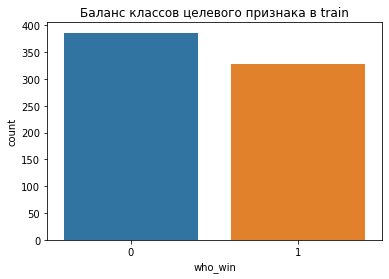

,count,% of total
0,386,54.14
1,327,45.86


In [6]:
# глянем ещё на балланс классов в трейне 
sns.countplot(x=train.who_win)
plt.title('Баланс классов целевого признака в train')
plt.show()
class_ratio = train['who_win'].value_counts().to_frame().rename(columns = {'who_win': 'count'})
class_ratio['% of total'] = round(((train['who_win'].value_counts()/ len(train))*100), 2)
display(class_ratio)

С данными, в целом, всё неплохо. В большинстве своем признаки численные. Баланс класов в train не нарушен. 
Есть немного пропусков в players_feats, но посмотрим останутся они после мерджа с train 
Смерджим `train.csv` и `players_feats.csv` по `train.map_id == players_feats.map_id and train.team{1|2}_id == players_feats.team_id`.


In [33]:
# делаем это через фуннкцию чтобы соблюсти второе условие train.team{1|2}_id == players_feats.team_id
def enriched(df, col):
    df_enriched = df.merge(players_feats, left_on=['map_id', col], right_on=['map_id', 'team_id'], how = 'inner')
    display(df_enriched.head(10))
    print('Размер данных', df_enriched.shape)
    print('Пропуски у', df_enriched[df_enriched.isnull().any(axis=1)].shape[0], 'объектов из', df_enriched.shape[0])
    return df_enriched

In [34]:
pd.set_option('display.max_columns', None)
train_enriched_1 = enriched(train, 'team1_id')

,map_id,team1_id,team2_id,map_name_x,who_win,p1_id,p1_total_kills,p1_headshots,p1_total_deaths,p1_kd_ratio,p1_damage_per_round,p1_grenade_damage_per_round,p1_maps_played,p1_rounds_played,p1_kills_per_round,p1_assists_per_round,p1_deaths_per_round,p1_saved_by_teammate_per_round,p1_saved_teammates_per_round,p1_rating,p1_kill_death,p1_kill_round,p1_rounds_with_kills,p1_kill_death_difference,p1_total_opening_kills,p1_total_opening_deaths,p1_opening_kill_ratio,p1_opening_kill_rating,p1_team_win_percent_after_first_kill,p1_first_kill_in_won_rounds,p2_id,p2_total_kills,p2_headshots,p2_total_deaths,p2_kd_ratio,p2_damage_per_round,p2_grenade_damage_per_round,p2_maps_played,p2_rounds_played,p2_kills_per_round,p2_assists_per_round,p2_deaths_per_round,p2_saved_by_teammate_per_round,p2_saved_teammates_per_round,p2_rating,p2_kill_death,p2_kill_round,p2_rounds_with_kills,p2_kill_death_difference,p2_total_opening_kills,p2_total_opening_deaths,p2_opening_kill_ratio,p2_opening_kill_rating,p2_team_win_percent_after_first_kill,p2_first_kill_in_won_rounds,p3_id,p3_total_kills,p3_headshots,p3_total_deaths,p3_kd_ratio,p3_damage_per_round,p3_grenade_damage_per_round,p3_maps_played,p3_rounds_played,p3_kills_per_round,p3_assists_per_round,p3_deaths_per_round,p3_saved_by_teammate_per_round,p3_saved_teammates_per_round,p3_rating,p3_kill_death,p3_kill_round,p3_rounds_with_kills,p3_kill_death_difference,p3_total_opening_kills,p3_total_opening_deaths,p3_opening_kill_ratio,p3_opening_kill_rating,p3_team_win_percent_after_first_kill,p3_first_kill_in_won_rounds,p4_id,p4_total_kills,p4_headshots,p4_total_deaths,p4_kd_ratio,p4_damage_per_round,p4_grenade_damage_per_round,p4_maps_played,p4_rounds_played,p4_kills_per_round,p4_assists_per_round,p4_deaths_per_round,p4_saved_by_teammate_per_round,p4_saved_teammates_per_round,p4_rating,p4_kill_death,p4_kill_round,p4_rounds_with_kills,p4_kill_death_difference,p4_total_opening_kills,p4_total_opening_deaths,p4_opening_kill_ratio,p4_opening_kill_rating,p4_team_win_percent_after_first_kill,p4_first_kill_in_won_rounds,p5_id,p5_total_kills,p5_headshots,p5_total_deaths,p5_kd_ratio,p5_damage_per_round,p5_grenade_damage_per_round,p5_maps_played,p5_rounds_played,p5_kills_per_round,p5_assists_per_round,p5_deaths_per_round,p5_saved_by_teammate_per_round,p5_saved_teammates_per_round,p5_rating,p5_kill_death,p5_kill_round,p5_rounds_with_kills,p5_kill_death_difference,p5_total_opening_kills,p5_total_opening_deaths,p5_opening_kill_ratio,p5_opening_kill_rating,p5_team_win_percent_after_first_kill,p5_first_kill_in_won_rounds,team_id,map_name_y
0,289,6665,7718,Ancient,0,4954,258,36.0,293,0.88,71.1,6.3,17,454,0.57,0.20,0.65,0.12,0.07,0.98,0.88,0.57,184,-35,32,39,0.82,0.88,71.9,9.5,7412,263,40.7,298,0.88,67.0,4.7,17,454,0.58,0.13,0.66,0.08,0.07,0.95,0.88,0.58,179,-35,42,55,0.76,0.93,78.6,13.7,9078,356,54.8,303,1.17,90.8,4.5,16,431,0.83,0.14,0.70,0.08,0.07,1.23,1.17,0.83,220,53,67,63,1.06,1.20,73.1,20.9,13300,153,30.7,123,1.24,68.8,5.0,8,210,0.73,0.08,0.59,0.10,0.12,1.08,1.24,0.73,105,30,12,12,1.00,0.86,66.7,7.1,15165,318,36.8,263,1.21,81.4,8.1,16,431,0.74,0.14,0.61,0.06,0.11,1.19,1.21,0.74,210,55,55,33,1.67,1.18,83.6,19.7,6665,Ancient
1,715,4411,10577,Inferno,0,8611,178,39.3,208,0.86,64.1,6.5,12,320,0.56,0.14,0.65,0.09,0.10,0.94,0.86,0.56,133,-30,25,16,1.56,0.97,68.0,11.3,9278,277,49.8,293,0.95,68.1,5.4,17,443,0.63,0.13,0.66,0.13,0.12,1.00,0.95,0.63,186,-16,37,38,0.97,0.94,73.0,12.6,9766,286,37.1,308,0.93,74.4,10.0,17,443,0.65,0.14,0.70,0.07,0.08,0.98,0.93,0.65,189,-22,60,71,0.85,1.08,65.0,18.1,13666,224,58.9,220,1.02,80.9,10.9,13,343,0.65,0.15,0.64,0.11,0.09,1.15,1.02,0.65,148,4,60,52,1.15,1.29,75.0,23.2,14218,269,40.5,292,0.92,70.4,7.7,17,443,0.61,0.16,0.66,0.12,0.12,1.01,0.92,0.61,186,-23,47,49,0.96,1.01,74.5,16.3,4411,Inferno
2,157,11251,9455,Nuke,1,7938,494,52.8,397,1.24,94.0,5.8,22,596,0.83,0.16,0.67,0.11,0.08,1.31,1.09,0.76,198,26,82,46,1.78,1.51,80.5,32.4,8574,424,26.7,344,1.23,73.0,3.0,22,596,0.71,0.10,0.58,0.04,0.06,1.12,1.15,0.69

Размер данных (713, 132)
Пропуски у 5 объектов из 713


In [35]:
train_enriched_2 = enriched(train, 'team2_id')

,map_id,team1_id,team2_id,map_name_x,who_win,p1_id,p1_total_kills,p1_headshots,p1_total_deaths,p1_kd_ratio,p1_damage_per_round,p1_grenade_damage_per_round,p1_maps_played,p1_rounds_played,p1_kills_per_round,p1_assists_per_round,p1_deaths_per_round,p1_saved_by_teammate_per_round,p1_saved_teammates_per_round,p1_rating,p1_kill_death,p1_kill_round,p1_rounds_with_kills,p1_kill_death_difference,p1_total_opening_kills,p1_total_opening_deaths,p1_opening_kill_ratio,p1_opening_kill_rating,p1_team_win_percent_after_first_kill,p1_first_kill_in_won_rounds,p2_id,p2_total_kills,p2_headshots,p2_total_deaths,p2_kd_ratio,p2_damage_per_round,p2_grenade_damage_per_round,p2_maps_played,p2_rounds_played,p2_kills_per_round,p2_assists_per_round,p2_deaths_per_round,p2_saved_by_teammate_per_round,p2_saved_teammates_per_round,p2_rating,p2_kill_death,p2_kill_round,p2_rounds_with_kills,p2_kill_death_difference,p2_total_opening_kills,p2_total_opening_deaths,p2_opening_kill_ratio,p2_opening_kill_rating,p2_team_win_percent_after_first_kill,p2_first_kill_in_won_rounds,p3_id,p3_total_kills,p3_headshots,p3_total_deaths,p3_kd_ratio,p3_damage_per_round,p3_grenade_damage_per_round,p3_maps_played,p3_rounds_played,p3_kills_per_round,p3_assists_per_round,p3_deaths_per_round,p3_saved_by_teammate_per_round,p3_saved_teammates_per_round,p3_rating,p3_kill_death,p3_kill_round,p3_rounds_with_kills,p3_kill_death_difference,p3_total_opening_kills,p3_total_opening_deaths,p3_opening_kill_ratio,p3_opening_kill_rating,p3_team_win_percent_after_first_kill,p3_first_kill_in_won_rounds,p4_id,p4_total_kills,p4_headshots,p4_total_deaths,p4_kd_ratio,p4_damage_per_round,p4_grenade_damage_per_round,p4_maps_played,p4_rounds_played,p4_kills_per_round,p4_assists_per_round,p4_deaths_per_round,p4_saved_by_teammate_per_round,p4_saved_teammates_per_round,p4_rating,p4_kill_death,p4_kill_round,p4_rounds_with_kills,p4_kill_death_difference,p4_total_opening_kills,p4_total_opening_deaths,p4_opening_kill_ratio,p4_opening_kill_rating,p4_team_win_percent_after_first_kill,p4_first_kill_in_won_rounds,p5_id,p5_total_kills,p5_headshots,p5_total_deaths,p5_kd_ratio,p5_damage_per_round,p5_grenade_damage_per_round,p5_maps_played,p5_rounds_played,p5_kills_per_round,p5_assists_per_round,p5_deaths_per_round,p5_saved_by_teammate_per_round,p5_saved_teammates_per_round,p5_rating,p5_kill_death,p5_kill_round,p5_rounds_with_kills,p5_kill_death_difference,p5_total_opening_kills,p5_total_opening_deaths,p5_opening_kill_ratio,p5_opening_kill_rating,p5_team_win_percent_after_first_kill,p5_first_kill_in_won_rounds,team_id,map_name_y
0,289,6665,7718,Ancient,0,8371,126,46.0,117,1.08,71.7,4.8,7,183,0.69,0.13,0.64,0.04,0.10,1.02,1.08,0.69,82,9,16,21,0.76,0.91,56.2,10.7,9254,133,53.4,131,1.02,83.2,5.7,7,183,0.73,0.12,0.72,0.08,0.05,1.08,1.02,0.73,86,2,31,31,1.00,1.23,67.7,25.0,13093,101,50.5,130,0.78,68.7,3.5,7,183,0.55,0.15,0.71,0.03,0.09,0.86,0.78,0.55,68,-29,6,12,0.50,0.72,66.7,4.8,19164,122,27.9,102,1.20,63.3,2.9,7,183,0.67,0.05,0.56,0.03,0.06,1.07,1.20,0.67,79,20,18,7,2.57,1.09,55.6,11.9,19509,101,47.5,135,0.75,65.6,5.0,7,183,0.55,0.16,0.74,0.16,0.04,0.88,0.75,0.55,75,-34,21,20,1.05,1.06,76.2,19.0,7718,Ancient
1,715,4411,10577,Inferno,0,8488,523,53.0,525,1.00,67.2,2.8,32,836,0.63,0.09,0.63,0.10,0.11,1.00,0.93,0.59,244,-27,52,62,0.84,0.94,75.0,12.5,11199,470,54.3,539,0.87,62.1,6.8,32,836,0.56,0.11,0.64,0.13,0.06,0.97,0.83,0.55,215,-66,57,76,0.75,0.94,77.2,14.1,12810,595,59.0,529,1.12,77.0,3.9,32,836,0.71,0.10,0.63,0.08,0.08,1.12,1.11,0.71,272,42,51,43,1.19,0.99,76.5,12.5,15821,646,48.8,498,1.30,88.4,14.3,32,836,0.77,0.18,0.60,0.08,0.13,1.28,1.26,0.78,297,92,75,47,1.60,1.18,61.3,14.8,19069,459,25.7,341,1.35,74.0,4.9,24,623,0.74,0.11,0.55,0.09,0.08,1.24,1.43,0.78,197,90,64,25,2.56,1.39,75.0,23.3,10577,Inferno
2,157,11251,9455,Nuke,1,557,201,39.8,215,0.93,69.0,4.5,13,337,0.60,0.14,0.64,0.08,0.05,0.96,0.88,0.60,106,-19,22,27,0.81,0.94,72.7,14.5,2023,223,30.9,199,1.12,70.0,4.1,13,337,0.66,0.11,0.59,0.08,0.09,1.07,1.02,0.64,100,3,24,

Размер данных (713, 132)
Пропуски у 11 объектов из 713


In [10]:
# смотрим на пропуски
pd.set_option('display.max_columns', None)
train_enriched_1[train_enriched_1.isnull().any(axis=1)]

,map_id,team1_id,team2_id,map_name_x,who_win,p1_id,p1_total_kills,p1_headshots,p1_total_deaths,p1_kd_ratio,p1_damage_per_round,p1_grenade_damage_per_round,p1_maps_played,p1_rounds_played,p1_kills_per_round,p1_assists_per_round,p1_deaths_per_round,p1_saved_by_teammate_per_round,p1_saved_teammates_per_round,p1_rating,p1_kill_death,p1_kill_round,p1_rounds_with_kills,p1_kill_death_difference,p1_total_opening_kills,p1_total_opening_deaths,p1_opening_kill_ratio,p1_opening_kill_rating,p1_team_win_percent_after_first_kill,p1_first_kill_in_won_rounds,p2_id,p2_total_kills,p2_headshots,p2_total_deaths,p2_kd_ratio,p2_damage_per_round,p2_grenade_damage_per_round,p2_maps_played,p2_rounds_played,p2_kills_per_round,p2_assists_per_round,p2_deaths_per_round,p2_saved_by_teammate_per_round,p2_saved_teammates_per_round,p2_rating,p2_kill_death,p2_kill_round,p2_rounds_with_kills,p2_kill_death_difference,p2_total_opening_kills,p2_total_opening_deaths,p2_opening_kill_ratio,p2_opening_kill_rating,p2_team_win_percent_after_first_kill,p2_first_kill_in_won_rounds,p3_id,p3_total_kills,p3_headshots,p3_total_deaths,p3_kd_ratio,p3_damage_per_round,p3_grenade_damage_per_round,p3_maps_played,p3_rounds_played,p3_kills_per_round,p3_assists_per_round,p3_deaths_per_round,p3_saved_by_teammate_per_round,p3_saved_teammates_per_round,p3_rating,p3_kill_death,p3_kill_round,p3_rounds_with_kills,p3_kill_death_difference,p3_total_opening_kills,p3_total_opening_deaths,p3_opening_kill_ratio,p3_opening_kill_rating,p3_team_win_percent_after_first_kill,p3_first_kill_in_won_rounds,p4_id,p4_total_kills,p4_headshots,p4_total_deaths,p4_kd_ratio,p4_damage_per_round,p4_grenade_damage_per_round,p4_maps_played,p4_rounds_played,p4_kills_per_round,p4_assists_per_round,p4_deaths_per_round,p4_saved_by_teammate_per_round,p4_saved_teammates_per_round,p4_rating,p4_kill_death,p4_kill_round,p4_rounds_with_kills,p4_kill_death_difference,p4_total_opening_kills,p4_total_opening_deaths,p4_opening_kill_ratio,p4_opening_kill_rating,p4_team_win_percent_after_first_kill,p4_first_kill_in_won_rounds,p5_id,p5_total_kills,p5_headshots,p5_total_deaths,p5_kd_ratio,p5_damage_per_round,p5_grenade_damage_per_round,p5_maps_played,p5_rounds_played,p5_kills_per_round,p5_assists_per_round,p5_deaths_per_round,p5_saved_by_teammate_per_round,p5_saved_teammates_per_round,p5_rating,p5_kill_death,p5_kill_round,p5_rounds_with_kills,p5_kill_death_difference,p5_total_opening_kills,p5_total_opening_deaths,p5_opening_kill_ratio,p5_opening_kill_rating,p5_team_win_percent_after_first_kill,p5_first_kill_in_won_rounds,team_id,map_name_y
42,21,4411,7718,Vertigo,0,8611,62,33.9,69,0.90,64.4,5.5,4,100,0.62,0.08,0.69,0.13,0.16,0.96,0.90,0.62,43,-7,7,10,0.7,0.85,71.4,12.5,9278,14,50.0,18,0.78,82.7,6.1,1,22,0.64,0.05,0.82,0.05,0.00,0.73,0.78,0.64,9,-4,0,4,0.00,0.36,NaN,0.0,9766,10,50.0,21,0.48,63.9,0.7,1,22,0.45,0.23,0.95,0.09,0.14,0.56,0.48,0.45,7,-11,1,1,1.0,0.82,100.0,16.7,14218,8,37.5,18,0.44,45.7,8.0,1,22,0.36,0.05,0.82,0.05,0.05,0.50,0.44,0.36,5,-10,1,2,0.50,0.74,100.0,16.7,16726,445,24.7,357,1.25,80.1,3.1,22,568,0.78,0.14,0.63,0.09,0.11,1.19,1.12,0.75,101,16,23,16,1.44,1.12,73.9,18.9,4411,Vertigo
109,386,6211,11585,Dust2,1,9102,86,50.0,71,1.21,73.6,4.1,5,123,0.70,0.11,0.58,0.12,0.16,1.12,0.43,0.38,8,-12,3,2,1.5,1.15,100.0,37.5,10588,70,47.1,49,1.43,73.9,8.5,4,99,0.71,0.12,0.49,0.12,0.10,1.19,0.00,0.00,0,0,0,0,0.00,0.00,0.0,0.0,11139,100,27.0,75,1.33,84.7,3.0,5,123,0.81,0.13,0.61,0.07,0.10,1.33,0.76,0.67,10,-5,3,1,3.0,1.22,33.3,12.5,11140,88,47.7,74,1.19,84.5,9.6,5,123,0.72,0.17,0.60,0.12,0.10,1.18,0.43,0.38,6,-12,0,6,0.00,0.25,NaN,0.0,11162,73,52.1,84,0.87,67.0,3.4,5,123,0.59,0.15,0.68,0.11,0.07,0.95,1.05,0.88,12,1,0,5,0.00,0.32,NaN,0.0,6211,Dust2
159,288,4863,9565,Overpass,1,7028,85,50.6,91,0.93,68.9,1.8,6,150,0.57,0.14,0.61,0.06,0.06,0.97,0.38,0.32,6,-10,0,4,0.0,0.32,NaN,0.0,7131,94,40.4,92,1.02,70.5,4.8,6,150,0.63,0.08,0.61,0.09,0.11,1.09,0.59,0.53,9,-7,1,2,0.50,0.75,100.0,33.3,8552,107,43.0,100,1.07,76.0,1.4,6,150,0.71,0.13,0.

Есть дублирующиеся признаки в конце таблицы 'team_id' и 'map_name_y', удалим их.        
Пропусков мало, логику заполнения тут не проследишь особо (статистика игры).    
Попробуем снести эти 5 строк из датафрейма, либо заменить на 0

In [11]:
train_enriched_1= train_enriched_1.drop(['team_id', 'map_name_y'], axis=1)
train_enriched_1_drop = train_enriched_1.dropna()
train_enriched_1_fill0 = train_enriched_1.fillna(0)

train_enriched_2= train_enriched_2.drop(['team_id', 'map_name_y'], axis=1)
train_enriched_2_drop = train_enriched_2.dropna()
train_enriched_2_fill0 = train_enriched_2.fillna(0)

In [12]:
# Числовые признаки
num_cols = train_enriched_1.drop(['map_name_x', 'who_win'], axis=1).columns.tolist()

# Категориальные признаки
cat_cols = ['map_name_x']

feature_cols = num_cols + cat_cols
target_col =  'who_win'

In [13]:
# функция разбивки данных на признаки и таргет для линейной модели и их копии для CatBoost
def fut_targ(df):
    return df.drop(target_col, axis=1), df[target_col], df.drop(target_col, axis=1).copy(), df[target_col].copy()    

In [14]:
feature_train_1_drop, target_train_1_drop, X_train_1_drop_before, y_train_1_drop_before = fut_targ(train_enriched_1_drop)
feature_train_1_fill0, target_train_1_fill0, X_train_1_fill0_before, y_train_1_fill0_before = fut_targ(train_enriched_1_fill0)

feature_train_2_drop, target_train_2_drop, X_train_2_drop_before, y_train_2_drop_before = fut_targ(train_enriched_2_drop)
feature_train_2_fill0, target_train_2_fill0, X_train_2_fill0_before, y_train_2_fill0_before = fut_targ(train_enriched_2_fill0)

### Применение линейных моделей (3 балла)

1) Обработаем данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируем числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

In [15]:
# масштабируем численные признаки через StandardScaler, а категориальные трансформируем через OneHotEncoder 

prep_pipe = ColumnTransformer([
        ('num_scaler', StandardScaler(), num_cols),
        ('cat_ohe', OneHotEncoder(sparse=False), cat_cols)
    ])

In [16]:
# делаем pipeline с прдеобработкой и моделью
logreg = make_pipeline(prep_pipe, LogisticRegression(random_state=42))

In [17]:
# сетка подбора гиперпараметров + gridserch
param_grid = {
    'logisticregression__max_iter': [15, 20, 25, 30], #[20, 50, 100, 150],
    'logisticregression__penalty' : ['l1', 'l2', 'elasticnet', None],
    'logisticregression__C': [100, 10, 1, 0.1, 0.01, 0.001],
    'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

In [18]:
# обучаем линейную модель_1 c drop'ом пропусков
model_1_drop = GridSearchCV(logreg, param_grid, cv=5, verbose=0, scoring='roc_auc', refit=True, n_jobs=-1)
model_1_drop.fit(feature_train_1_drop,target_train_1_drop)

# смотрим лучше параметры
print(f'Метрика ROC-AUC линейной модели: {round(model_1_drop.best_score_,4)}')
print(f'Лучшие параметры: {model_1_drop.best_params_}')

Метрика ROC-AUC линейной модели: 0.5831
Лучшие параметры: {'logisticregression__C': 1, 'logisticregression__max_iter': 25, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}


In [19]:
# обучаем линейную модель_1 с заменой пропусков на 0
model_1_fill0 = GridSearchCV(logreg, param_grid, cv=5, verbose=0, scoring='roc_auc', refit=True, n_jobs=-1)
model_1_fill0.fit(feature_train_1_fill0,target_train_1_fill0)

# смотрим лучше параметры
print(f'Метрика ROC-AUC линейной модели: {round(model_1_fill0.best_score_,4)}')
print(f'Лучшие параметры: {model_1_fill0.best_params_}')

Метрика ROC-AUC линейной модели: 0.5787
Лучшие параметры: {'logisticregression__C': 0.1, 'logisticregression__max_iter': 15, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'saga'}


In [20]:
# обучаем линейную модель_2 c drop'ом пропусков
model_2_drop = GridSearchCV(logreg, param_grid, cv=5, verbose=0, scoring='roc_auc', refit=True, n_jobs=-1)
model_2_drop.fit(feature_train_2_drop,target_train_2_drop)

# смотрим лучше параметры
print(f'Метрика ROC-AUC линейной модели: {round(model_2_drop.best_score_,4)}')
print(f'Лучшие параметры: {model_2_drop.best_params_}')

Метрика ROC-AUC линейной модели: 0.5809
Лучшие параметры: {'logisticregression__C': 1, 'logisticregression__max_iter': 15, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}


In [21]:
# обучаем линейную модель_2 с заменой пропусков на 0
model_2_fill0 = GridSearchCV(logreg, param_grid, cv=5, verbose=0, scoring='roc_auc', refit=True, n_jobs=-1)
model_2_fill0.fit(feature_train_2_fill0,target_train_2_fill0)

# смотрим лучше параметры
print(f'Метрика ROC-AUC линейной модели: {round(model_2_fill0.best_score_,4)}')
print(f'Лучшие параметры: {model_2_fill0.best_params_}')

Метрика ROC-AUC линейной модели: 0.5813
Лучшие параметры: {'logisticregression__C': 1, 'logisticregression__max_iter': 20, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}


### Лучшее качество у линейной модели model_1_drop    
### ROC-AUC: 0.5831    
### параметры: С = 1, max_iter = 25, penalty ='l1', solver = 'liblinear'

## Применение градиентного бустинга 
*В бэггинг со случайным лесом не полез, т.к.  много признаков

Мы будем использовать Catboost, поэтому нам не надо кодировать категориальные признаки.     
Catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделим выборку на train/valid. Протестируем Catboost cо стандартными параметрами.

In [22]:
X_train_1_drop, X_valid_1_drop, y_train_1_drop, y_valid_1_drop = train_test_split(X_train_1_drop_before, y_train_1_drop_before, train_size=0.8, random_state=42)
X_train_1_fill0, X_valid_1_fill0, y_train_1_fill0, y_valid_1_fill0 = train_test_split(X_train_1_fill0_before, y_train_1_fill0_before, train_size=0.8, random_state=42)

X_train_2_drop, X_valid_2_drop, y_train_2_drop, y_valid_2_drop = train_test_split(X_train_2_drop_before, y_train_2_drop_before, train_size=0.8, random_state=42)
X_train_2_fill0, X_valid_2_fill0, y_train_2_fill0, y_valid_2_fill0 = train_test_split(X_train_2_fill0_before, y_train_2_fill0_before, train_size=0.8, random_state=42)

In [23]:
# обучаем CatBoost модель_1 c drop'ом пропусков
cb_default_1_drop = CatBoostClassifier(cat_features=cat_cols, silent=True)
cb_default_1_drop.fit(X_train_1_drop, y_train_1_drop, verbose=False)
y_predict_1_drop = cb_default_1_drop.predict_proba(X_valid_1_drop)[:, 1]

print(f'ROC-AUC valid: {roc_auc_score(y_valid_1_drop, cb_default_1_drop.predict_proba(X_valid_1_drop)[:, 1])}')

ROC-AUC valid: 0.564035964035964


In [24]:
# обучаем линейную модель_1 с заменой пропусков на 0
cb_default_1_fill0 = CatBoostClassifier(cat_features=cat_cols, silent=True)
cb_default_1_fill0.fit(X_train_1_fill0, y_train_1_fill0, verbose=False)
y_predict_1_fill0 = cb_default_1_fill0.predict_proba(X_valid_1_fill0)[:, 1]

print(f'ROC-AUC valid: {roc_auc_score(y_valid_1_fill0, cb_default_1_fill0.predict_proba(X_valid_1_fill0)[:, 1])}')

ROC-AUC valid: 0.5011806375442739


In [25]:
# обучаем CatBoost модель_2 c drop'ом пропусков
cb_default_2_drop = CatBoostClassifier(cat_features=cat_cols, silent=True)
cb_default_2_drop.fit(X_train_2_drop, y_train_2_drop, verbose=False)
y_predict_2_drop = cb_default_2_drop.predict_proba(X_valid_2_drop)[:, 1]

print(f'ROC-AUC valid: {roc_auc_score(y_valid_2_drop, cb_default_2_drop.predict_proba(X_valid_2_drop)[:, 1])}')

ROC-AUC valid: 0.4948068134607395


In [26]:
# обучаем линейную модель_2 с заменой пропусков на 0
cb_default_2_fill0 = CatBoostClassifier(cat_features=cat_cols,silent=True)
cb_default_2_fill0.fit(X_train_2_fill0, y_train_2_fill0, verbose=False)
y_predict_2_fill0 = cb_default_2_fill0.predict_proba(X_valid_2_fill0)[:, 1]

print(f'ROC-AUC valid: {roc_auc_score(y_valid_1_fill0, cb_default_1_fill0.predict_proba(X_valid_2_fill0)[:, 1])}')

ROC-AUC valid: 0.45749704840613936


Как-то не мощно для  бустинга получается. Лучшие результаты незначительно выше константной модели...     
Покрутим гиперпараметры. Но понятно, что из 4х рассматриваемых модель_1 c drop'ом пропусков перспективней всего.

In [27]:
gs_param = {
    'n_estimators': [100, 200, 300],
    'max_depth': range(5, 7, 9),
    'learning_rate': np.linspace(0.01, 0.06, 6)
}
gs_catboost = GridSearchCV(
    estimator=cb_default_1_drop,
    param_grid=gs_param,
    scoring='roc_auc',
    verbose=20)
gs_catboost.fit(X_train_1_drop, y_train_1_drop)
print(f'Лучшие параметры : {gs_catboost.best_params_}')
print(f'Лучшая метрика : {gs_catboost.best_score_}')

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5; 1/18] START learning_rate=0.01, max_depth=5, n_estimators=100..........
[CV 1/5; 1/18] END learning_rate=0.01, max_depth=5, n_estimators=100;, score=0.462 total time=   3.3s
[CV 2/5; 1/18] START learning_rate=0.01, max_depth=5, n_estimators=100..........
[CV 2/5; 1/18] END learning_rate=0.01, max_depth=5, n_estimators=100;, score=0.515 total time=   3.4s
[CV 3/5; 1/18] START learning_rate=0.01, max_depth=5, n_estimators=100..........
[CV 3/5; 1/18] END learning_rate=0.01, max_depth=5, n_estimators=100;, score=0.560 total time=   3.3s
[CV 4/5; 1/18] START learning_rate=0.01, max_depth=5, n_estimators=100..........
[CV 4/5; 1/18] END learning_rate=0.01, max_depth=5, n_estimators=100;, score=0.538 total time=   3.2s
[CV 5/5; 1/18] START learning_rate=0.01, max_depth=5, n_estimators=100..........
[CV 5/5; 1/18] END learning_rate=0.01, max_depth=5, n_estimators=100;, score=0.468 total time=   3.2s
[CV 1/5; 2/18] START lea

In [72]:
# добаим еще гиперпараметров для улучшения модели

best_catboost = CatBoostClassifier(
    n_estimators=100,
    max_depth=5,
    subsample=0.6,
    l2_leaf_reg=10,
    random_strength=5,
    learning_rate=0.03,
    min_data_in_leaf=100,
    grow_policy='Lossguide',
    silent=True,
    eval_metric='AUC:hints=skip_train~false',
    cat_features=cat_cols)
best_catboost.fit(X_train_1_drop_before, y_train_1_drop_before)
print(f'Лучшая метрика : {best_catboost.best_score_}')

Лучшая метрика : {'learn': {'Logloss': 0.6517564890548301, 'AUC': 0.7779103973765432}}


### Лучшее качество у CatBoost модели c подобранными гмперпараметрами
### ROC-AUC = 0.7779
### параметры: n_estimators=100, max_depth=5, subsample=0.6, l2_leaf_reg=10, random_strength=5, learning_rate=0.03, min_data_in_leaf=100, grow_policy='Lossguide', eval_metric='AUC:hints=skip_train~false'

# Предсказания

In [85]:
test_data = enriched(test, 'team1_id')
test_data = test_data.drop(['index','team_id', 'map_name_y'], axis=1)

,index,map_id,team1_id,team2_id,map_name_x,p1_id,p1_total_kills,p1_headshots,p1_total_deaths,p1_kd_ratio,p1_damage_per_round,p1_grenade_damage_per_round,p1_maps_played,p1_rounds_played,p1_kills_per_round,p1_assists_per_round,p1_deaths_per_round,p1_saved_by_teammate_per_round,p1_saved_teammates_per_round,p1_rating,p1_kill_death,p1_kill_round,p1_rounds_with_kills,p1_kill_death_difference,p1_total_opening_kills,p1_total_opening_deaths,p1_opening_kill_ratio,p1_opening_kill_rating,p1_team_win_percent_after_first_kill,p1_first_kill_in_won_rounds,p2_id,p2_total_kills,p2_headshots,p2_total_deaths,p2_kd_ratio,p2_damage_per_round,p2_grenade_damage_per_round,p2_maps_played,p2_rounds_played,p2_kills_per_round,p2_assists_per_round,p2_deaths_per_round,p2_saved_by_teammate_per_round,p2_saved_teammates_per_round,p2_rating,p2_kill_death,p2_kill_round,p2_rounds_with_kills,p2_kill_death_difference,p2_total_opening_kills,p2_total_opening_deaths,p2_opening_kill_ratio,p2_opening_kill_rating,p2_team_win_percent_after_first_kill,p2_first_kill_in_won_rounds,p3_id,p3_total_kills,p3_headshots,p3_total_deaths,p3_kd_ratio,p3_damage_per_round,p3_grenade_damage_per_round,p3_maps_played,p3_rounds_played,p3_kills_per_round,p3_assists_per_round,p3_deaths_per_round,p3_saved_by_teammate_per_round,p3_saved_teammates_per_round,p3_rating,p3_kill_death,p3_kill_round,p3_rounds_with_kills,p3_kill_death_difference,p3_total_opening_kills,p3_total_opening_deaths,p3_opening_kill_ratio,p3_opening_kill_rating,p3_team_win_percent_after_first_kill,p3_first_kill_in_won_rounds,p4_id,p4_total_kills,p4_headshots,p4_total_deaths,p4_kd_ratio,p4_damage_per_round,p4_grenade_damage_per_round,p4_maps_played,p4_rounds_played,p4_kills_per_round,p4_assists_per_round,p4_deaths_per_round,p4_saved_by_teammate_per_round,p4_saved_teammates_per_round,p4_rating,p4_kill_death,p4_kill_round,p4_rounds_with_kills,p4_kill_death_difference,p4_total_opening_kills,p4_total_opening_deaths,p4_opening_kill_ratio,p4_opening_kill_rating,p4_team_win_percent_after_first_kill,p4_first_kill_in_won_rounds,p5_id,p5_total_kills,p5_headshots,p5_total_deaths,p5_kd_ratio,p5_damage_per_round,p5_grenade_damage_per_round,p5_maps_played,p5_rounds_played,p5_kills_per_round,p5_assists_per_round,p5_deaths_per_round,p5_saved_by_teammate_per_round,p5_saved_teammates_per_round,p5_rating,p5_kill_death,p5_kill_round,p5_rounds_with_kills,p5_kill_death_difference,p5_total_opening_kills,p5_total_opening_deaths,p5_opening_kill_ratio,p5_opening_kill_rating,p5_team_win_percent_after_first_kill,p5_first_kill_in_won_rounds,team_id,map_name_y
0,713,309,5973,5752,Dust2,7687,105,53.3,108,0.97,70.7,6.3,7,162,0.65,0.12,0.67,0.15,0.10,1.08,1.04,0.68,61,4,18,12,1.50,1.17,72.2,17.1,8520,114,39.5,93,1.23,76.2,4.2,7,162,0.70,0.12,0.57,0.11,0.07,1.16,1.21,0.66,60,16,6,4,1.50,0.84,83.3,6.6,8738,123,39.8,116,1.06,82.8,5.8,7,162,0.76,0.17,0.72,0.09,0.17,1.12,1.11,0.79,67,11,16,14,1.14,1.08,62.5,13.2,13249,122,21.3,94,1.30,75.0,2.1,7,162,0.75,0.09,0.58,0.10,0.13,1.21,1.32,0.78,73,26,24,12,2.00,1.39,83.3,26.3,13915,262,53.8,211,1.24,85.7,4.2,12,322,0.81,0.11,0.66,0.08,0.09,1.22,1.24,0.81,170,51,51,37,1.38,1.27,76.5,22.5,5973,Dust2
1,714,541,5973,5752,Vertigo,7687,230,42.2,243,0.95,68.5,6.4,15,373,0.62,0.15,0.65,0.15,0.13,1.02,0.84,0.58,139,-36,30,37,0.81,0.93,63.3,11.0,8520,298,36.2,224,1.33,88.0,8.9,15,373,0.80,0.15,0.60,0.11,0.10,1.26,1.22,0.77,181,47,23,19,1.21,0.91,87.0,11.6,8738,291,42.6,254,1.15,85.5,6.4,15,373,0.78,0.15,0.68,0.09,0.13,1.20,1.09,0.77,163,21,55,42,1.31,1.27,67.3,21.5,13249,305,34.8,255,1.20,74.5,2.7,16,408,0.75,0.10,0.62,0.12,0.15,1.14,1.16,0.74,171,34,28,25,1.12,0.96,78.6,12.8,13915,123,57.7,141,0.87,75.3,6.8,7,186,0.66,0.18,0.76,0.11,0.09,0.99,0.87,0.66,80,-18,24,33,0.73,1.02,50.0,14.3,5973,Vertigo
2,715,1,8297,7020,Nuke,12521,270,42.6,334,0.81,78.9,4.5,17,422,0.64,0.16,0.79,0.09,0.07,0.96,0.78,0.63,163,-69,61,78,0.78,1.12,62.3,22.4,12553,316,42.1,266,1.19,78.0,3.7,17,422,0.75,0.10,0.63,0.07,0.09,1.11,1.11,0.73,183,27,32,28,1.14,

Размер данных (30, 132)
Пропуски у 0 объектов из 30


In [87]:
result = pd.DataFrame(columns=['index', 'who_win'])
result['index'] = test['index']
result['who_win'] = best_catboost.predict(test_data)
result.to_csv('./dimklimov_result.csv', index=False)
pd.read_csv('./dimklimov_result.csv').sample(10)

,index,who_win
27,740,0
28,741,0
18,731,0
1,714,0
21,734,0
7,720,0
4,717,0
23,736,0
3,716,0
14,727,0


Сомнительно, конечно, что предсказывает одну и ту же категорию, но таков результат.